## A4 Computational Code and Output
### Sean Meng 76349968

In [1]:
library(tidyverse, warn.conflicts = FALSE)
library(car)
library(patchwork)
library(broom)
library(ResourceSelection)
library(caret)
options(warn=-1)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


ResourceSelection 0.3-6 	 2023-06-27

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




**Model Building**: Fit an initial logistic regression model with all  predictors.

**Diagnostic Check**: Box-Tidwell Test: A formal statistical test for assessing linearity in the logit for continuous variables. It involves creating interaction terms between the continuous predictors and their natural logarithm and then testing the significance of these terms.

**Model Selection**: Apply both forward and backward selection methods to identify the most significant predictors, guided by the AIC. It balances the model's complexity and the explanatory power.

**Validation**: Use cross-validation(10-fold) to assess the model's predictive performance and prevent overfitting. Dividing our 5110 observations into 10 folds ensures that each fold is large enough to be representative of the dataset's diversity while allowing every data point to contribute to both the training and validation process.

**The Goodness of Fit**: Hosmer-Lemeshow Test will be used. A non-significant result (p> 0.05) suggests a good fit that the model's predictions are not significantly different from the observed values.

**Interpretation**: Provide a detailed interpretation of the final selected model, indicating the influence of each factor on stroke risk.


### Read dataset from the website into R.

In [2]:
data<-read_csv('https://raw.githubusercontent.com/seanmeng2001/STAT301/main/healthcare-dataset-stroke-data.csv')
head(data)

Rows: 5110 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): gender, ever_married, work_type, Residence_type, bmi, smoking_status
dbl (6): id, age, hypertension, heart_disease, avg_glucose_level, stroke

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>
9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,N/A,never smoked,1
31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24,never smoked,1
56669,Male,81,0,0,Yes,Private,Urban,186.21,29,formerly smoked,1


### Data Description:

The dataset chosen for this project comes from **Kaggle** and is focused on predicting the likelihood of a patient experiencing a stroke based on various parameters such as gender, age, health conditions, and smoking status. Each entry presents data for an individual patient. This dataset is of significant importance in light of the World Health Organization's (WHO) statement that strokes account for approximately 11% of total global deaths, making it the 2nd leading cause of death worldwide. By examining these critical parameters, the goal is to better understand and potentially mitigate the risk factors associated with strokes. The dataset can be accessed via the following link: 
https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset.


**Number of Observations:**  5110

**Number of Variables:** 12

**Variables Description:**

- **id** (Double): A unique identifier for each patient.

- **gender** (Character): Gender of the patient. It can be "Male", "Female", or "Other".

- **age** (Double): Age of the patient.

- **hypertension** (Double): Indicates the presence (1) or absence (0) of hypertension in the patient.

- **heart_disease** (Double): Indicates the presence (1) or absence (0) of any heart diseases in the patient.

- **ever_married** (Character): Whether the patient has ever been married. It can be "Yes" or "No".

- **work_type** (Character): Type of employment or occupation of the patient. The possible values are "children", "Govt_jov", "Never_worked", "Private", or "Self-employed".

- **Residence_type** (Character): Type of residence of the patient, either "Urban" or "Rural".

- **avg_glucose_level** (Double): Average glucose level in the patient's blood.

- **bmi** (Character): Body Mass Index of the patient.

- **smoking_status** (Character): Smoking status of the patient. It can be "formerly smoked", "never smoked", "smokes", or "Unknown". Unknown means that the information is unavailable for this patient."

- **stroke** (Double): Indicates if the patient had a stroke (1) or not (0).

This dataset has been compiled to provide insights into the potential risk factors and their relationship with stroke incidents. 

### Research Question:

**"How do various factors such as gender, age, hypertension, heart disease, marital status, employment type, residence, glucose levels, body mass index, and smoking habits influence the likelihood of a patient experiencing a stroke?"**

## Brief EDA:

### Data Clean:  
**All data** in this dataset are used in this research project since all variables seem like they might have associations with the response variable 'stroke'.  And it’s better to explore all the variables, then let the data choose which ones are useful.  
Clean and wrangle the data into a tidy format in following steps:

**1.** **Remove 'id'** column, the 'id' column is a simple enumeration of observations and holds no statistical meaning for our research, 'id' would not affect the 'stroke'.

**2.** **Converting Variables to Appropriate Data Types**  
The code converts several variables to factors, which is a necessary step for statistical modelling in R. Factors are used to represent categorical data, and by explicitly declaring variables such as gender, ever_married, work_type, Residence_type, and smoking_status as factors, the statistical models can correctly interpret these as categorical rather than continuous variables. The binary variables stroke, hypertension, and heart_disease are also converted to factors to ensure they are properly handled as categorical variables with two levels (0 and 1).

**3.** **NAs** in the BMI variable are replaced with the **mean BMI** of the non-missing data. This approach is taken to retain the full sample size, which preserves the power of the statistical analysis and avoids bias that could arise from simply excluding observations with missing data.   
(Imputing missing values with the mean is a common practice for dealing with missing numerical data when the assumption is that the missing values are randomly distributed.) 

**4. Check** for missing values. Ensure that the data is thoroughly cleansed of any missing values.

In [3]:
data <- data %>%
  select(-id) %>%
  mutate(across(c(gender, ever_married, work_type, Residence_type, smoking_status), as.factor),  
         hypertension = as.factor(hypertension),
         heart_disease = as.factor(heart_disease),
         bmi = as.numeric(bmi),
         bmi = ifelse(is.na(bmi), mean(bmi, na.rm = TRUE), bmi))
sum(is.na(data))

[1] 0

In [4]:
set.seed(123)
# split data into training and test sets
training_stroke  = data %>%
  sample_frac(0.7)
nrow(training_stroke)

testing_stroke = data %>%
  setdiff(training_stroke)
nrow(testing_stroke)


[1] 3577

[1] 1533

## Visualization

Firstly, we will visualize the relationship between **continuous** variables('age', 'avg_glucose_level', 'bmi') and **'stroke'**.   
Secondly, we will visualize the relationship between **categorical** variables("gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "smoking_status") and **'stroke'**.  
Thirdly, we will combine both the boxplots and the bar charts into one high quality **combo plot** sharing the **common story**(relations with the same response variable 'stroke').

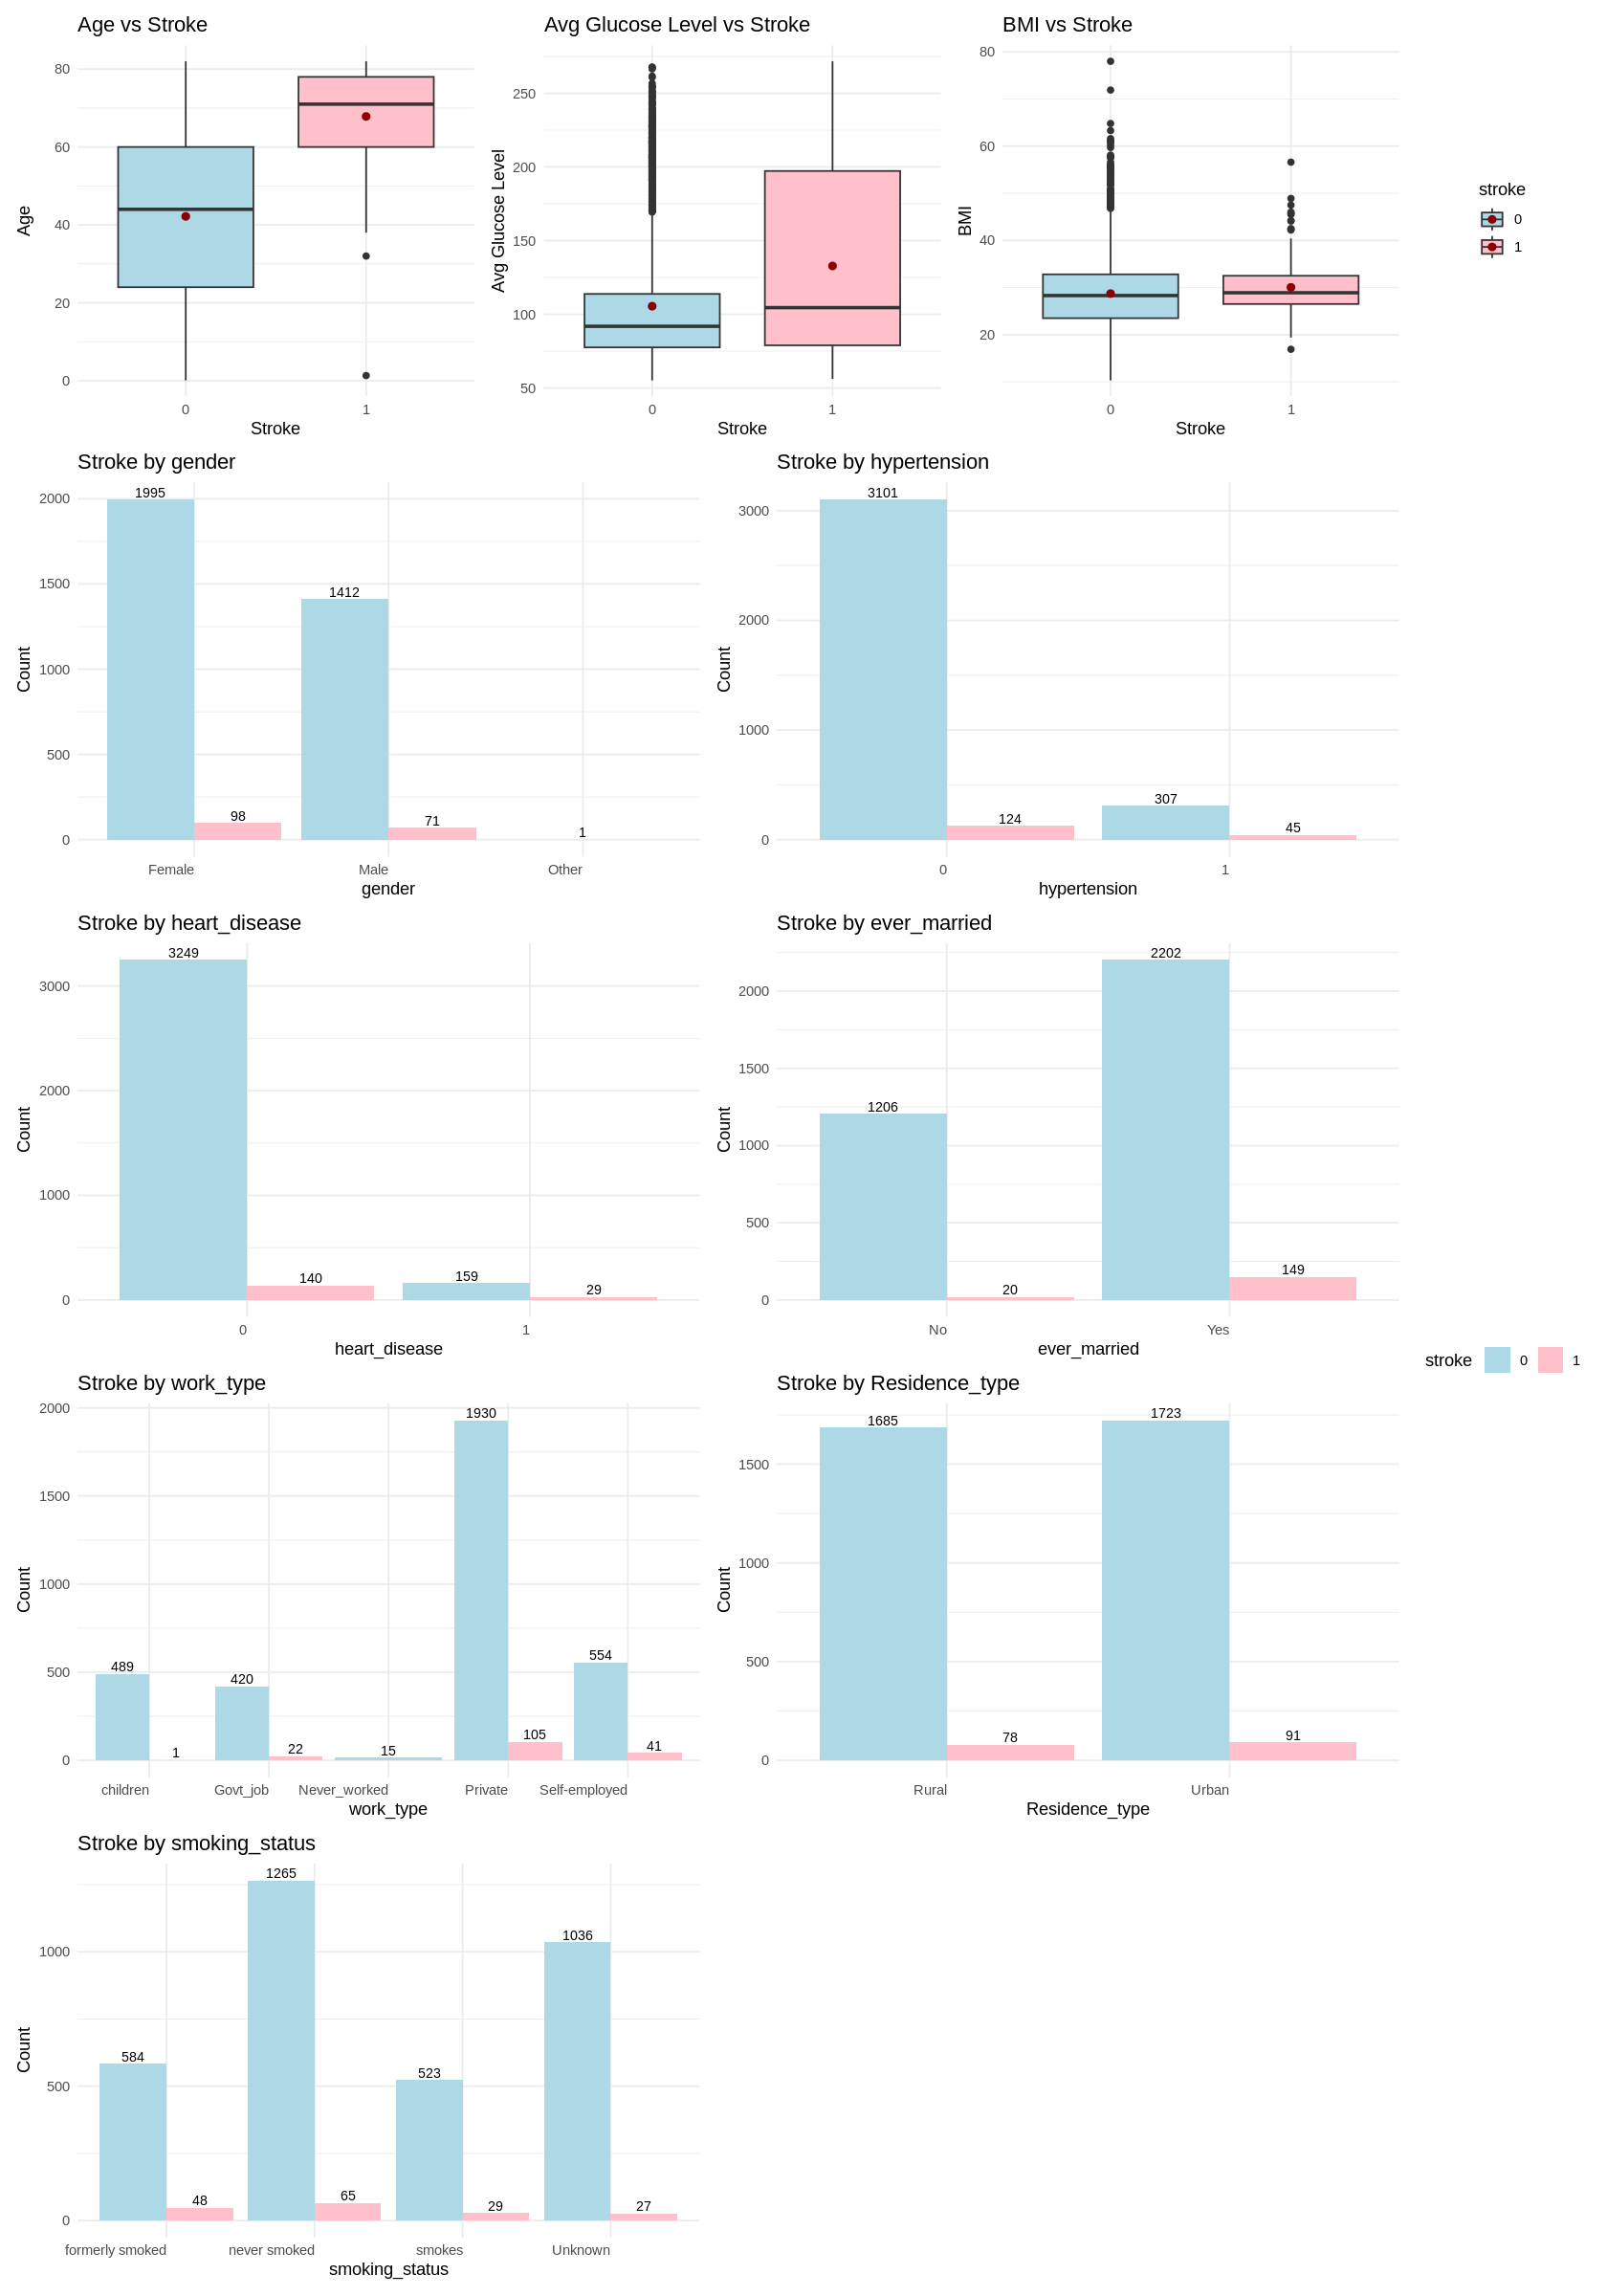

In [5]:
options(repr.plot.width = 14, repr.plot.height = 20)
training_stroke_plot<- training_stroke%>% 
mutate(stroke = as.factor(stroke))

# Boxplot for Age vs stroke
age_plot <- ggplot(training_stroke_plot, aes(x =stroke, y = age, fill = stroke)) +
  geom_boxplot() +
  stat_summary(fun = mean, geom = "point", shape = 20, size = 3, color = "darkred") +
  labs(x = "Stroke", y = "Age", title = "Age vs Stroke") +
  theme_minimal() +
  scale_fill_manual(values = c("lightblue", "pink"))

# Boxplot for Avg_glucose_level vs stroke
glucose_plot <- ggplot(training_stroke_plot, aes(x = stroke, y = avg_glucose_level, fill = stroke)) +
  geom_boxplot() +
  stat_summary(fun = mean, geom = "point", shape = 20, size = 3, color = "darkred") +
  labs(x = "Stroke", y = "Avg Glucose Level", title = "Avg Glucose Level vs Stroke") +
  theme_minimal() +
  scale_fill_manual(values = c("lightblue", "pink"))

# Boxplot for BMI vs stroke
bmi_plot <- ggplot(training_stroke_plot, aes(x = stroke, y = bmi, fill = stroke)) +
  geom_boxplot() +
  stat_summary(fun = mean, geom = "point", shape = 20, size = 3, color = "darkred") +
  labs(x = "Stroke", y = "BMI", title = "BMI vs Stroke") +
  theme_minimal() +
  scale_fill_manual(values = c("lightblue", "pink"))

# Combine the boxplots into one composite plot
boxplot_composite <- (age_plot | glucose_plot | bmi_plot) +
  plot_layout(guides = 'collect') & theme(legend.position = 'right')


# Bar charts for categorical variables("gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "smoking_status") vs stroke
categorical_variables <- c("gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "smoking_status")
plot_categorical_variable <- function(data, variable_name, response_variable) {
  ggplot(training_stroke_plot, aes_string(x = variable_name, fill = response_variable)) + 
    geom_bar(position = "dodge") +
    geom_text(stat='count', aes(label=..count..), position=position_dodge(width=0.9), vjust=-0.25, size=3) +
    scale_fill_manual(values = c("0" = "lightblue", "1" = "pink")) + 
    labs(title = paste("Stroke by", variable_name), x = variable_name, y = "Count") +
    theme_minimal() +
    theme(axis.text.x = element_text( hjust = 1), 
          legend.position = "bottom") 
}

bar_plots_list <- list()

for (var in categorical_variables) {
  bar_plots_list[[var]] <- plot_categorical_variable(data, var, "stroke")
}

bar_plot_composite <- wrap_plots(bar_plots_list, ncol = 2) +
  plot_layout(guides = 'collect')

 
# Combine the boxplots and bar charts together into 
combo_plot <- boxplot_composite / bar_plot_composite
combo_plot <- combo_plot + 
              plot_layout(heights = c(1, 5))

print(combo_plot)


### Briefly interpretation of the visualization:
Variables are likely associated with stroke: age, average glucose level, BMI, Hypertension, Heart Disease, Work Type, Smoking Status, ever_married( may confound with age)

## Methods

### Logistic Regression with Stepwise Model Selection

### Why is this method appropriate?
**Logistic regression** is suitable for our binary outcome (stroke occurrence). It can handle a mix of categorical and continuous variables, making it suitable for analyzing how different factors contribute to stroke risk. This method is excellent in determining the strength and direction of associations between various predictors and the likelihood of experiencing a stroke. By using logistic regression, we can estimate the odds of stroke occurrence in relation to individual predictors, providing valuable insights into how different factors affect stroke risk.

**The stepwise selection method** is chosen for its ability to effectively balance model complexity and fit. It combines forward and backward methods, starting by adding significant variables and then removing the less significant ones.

## Assumptions for Logistic Regression:
**Binary Response**: The response variable, stroke occurrence, is dichotomous(two possible responses), which meets the binary response requirement.

**Independence**: We assume that each patient's data is independent of another's, a prerequisite we will ensure during data collection.

**Variance Structure**: Logistic regression assumes the variance of the response variable is a function of its mean, suitable for our binary outcome.

**Linearity**: The logit is assumed to have a linear relationship with independent variables, and we will use empirical logit plots for continuous predictors to assess the linearity assumption.

## Plan

**Model Building**: Fit an initial logistic regression model with all  predictors.

**Diagnostic Check**: Empirical logit plots are used to check the linearity assumption for continuous variables. If non-linearity is indicated, methods like log transformation and polynomial terms will be used to address non-linearity since they are useful for handling skewed data.

**Model Selection**: Apply both forward and backward selection methods to identify the most significant predictors, guided by the AIC. It balances the model's complexity and the explanatory power.

**Validation**: Use cross-validation(10-fold) to assess the model's predictive performance and prevent overfitting. Dividing our 5110 observations into 10 folds ensures that each fold is large enough to be representative of the dataset's diversity while allowing every data point to contribute to both the training and validation process.

**The Goodness of Fit**: Hosmer-Lemeshow Test will be used. A non-significant result (p> 0.05) suggests a good fit that the model's predictions are not significantly different from the observed values.

**Interpretation**: Provide a detailed interpretation of the final selected model, indicating the influence of each factor on stroke risk.


## Potential Limitations & Weaknesses

**Biases in Data Collection**:
Biases in data collection such as selection bias or missing data would impact the model's validity and generalizability.

**Risk of Overfitting**:
Stepwise model selection with a large set of predictors may cause overfitting.

**Subjectivity of Plots**:
The interpretation of empirical logit plots can be subjective. Non-linear relationships might be misinterpreted.

**Outliers**:
If there are outliers present, they might skew the results and impact the interpretation of the data.

**Confounders**: If confounders are not correctly addressed, they will bias the estimated impact of the predictors on the outcome.

## Implementation of a proposed model

#### Model Building: 
Fit the initial logistic regression model with all predictors

In [6]:
logit_model <- glm(stroke ~ .,family = binomial(), data = training_stroke_plot)

#### Diagnostic Check:  
Using empirical logit plots to check the assumption of Linearity.

In [7]:
# options(repr.plot.width = 8, repr.plot.height = 8)

# plot_empirical_logit <- function(data, continuous_var, response_var) {
#   data_summary <- data %>%
#     group_by({{ continuous_var }}) %>%
#     summarise(Stroke_Prob = mean({{ response_var }} == 1), .groups = 'drop') %>%
#     mutate(Empirical_Logit = log(Stroke_Prob / (1 - Stroke_Prob)))

#   ggplot(data_summary, aes(x = {{ continuous_var }}, y = Empirical_Logit)) +
#     geom_point() +
#     geom_smooth(method = "glm", method.args = list(family = "binomial"), se = FALSE) +
#     labs(title = paste("Empirical Logit Plot for", deparse(substitute(continuous_var))),
#          x = deparse(substitute(continuous_var)),
#          y = "Empirical Logit") +
#     theme_minimal()
# }

# plot_empirical_logit(training_stroke, age, stroke)
# plot_empirical_logit(training_stroke, avg_glucose_level, stroke)
# plot_empirical_logit(training_stroke, bmi, stroke)



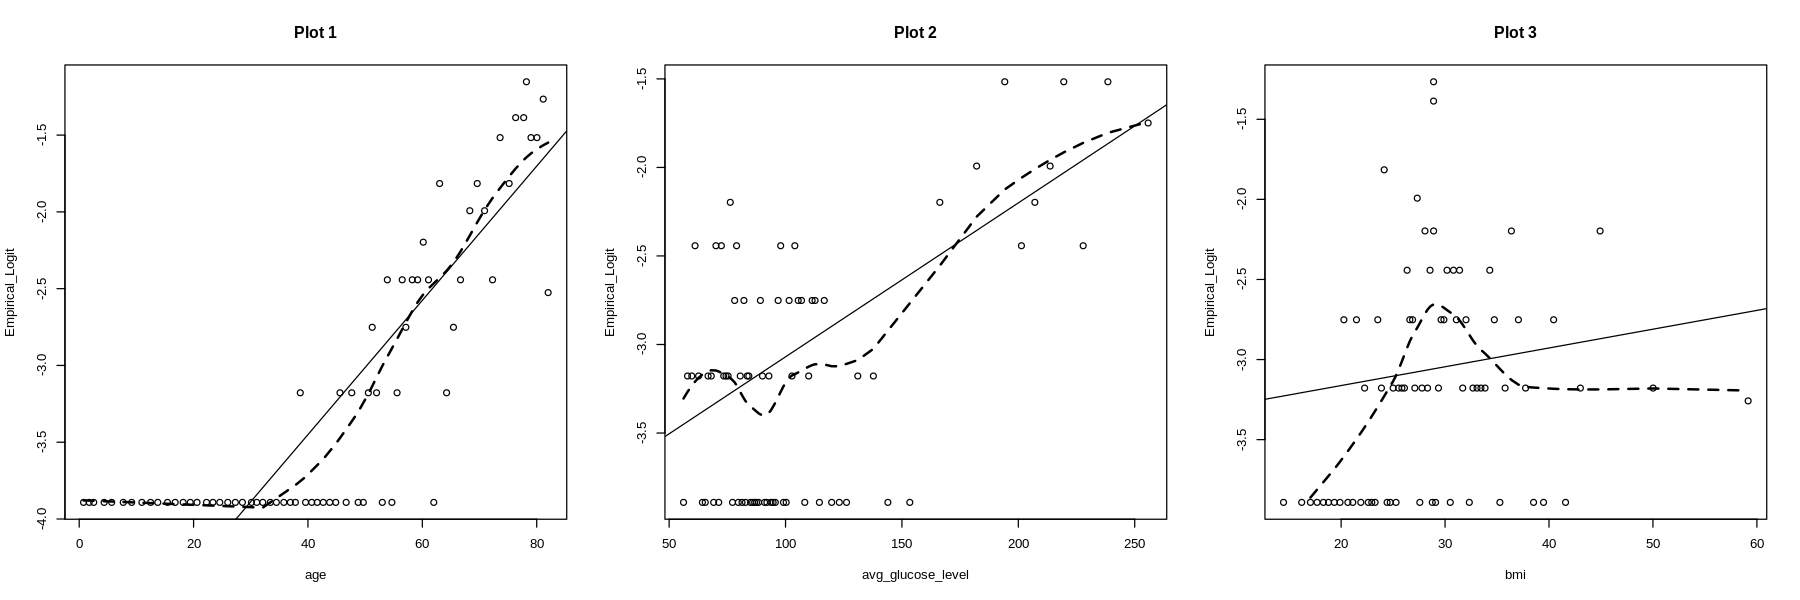

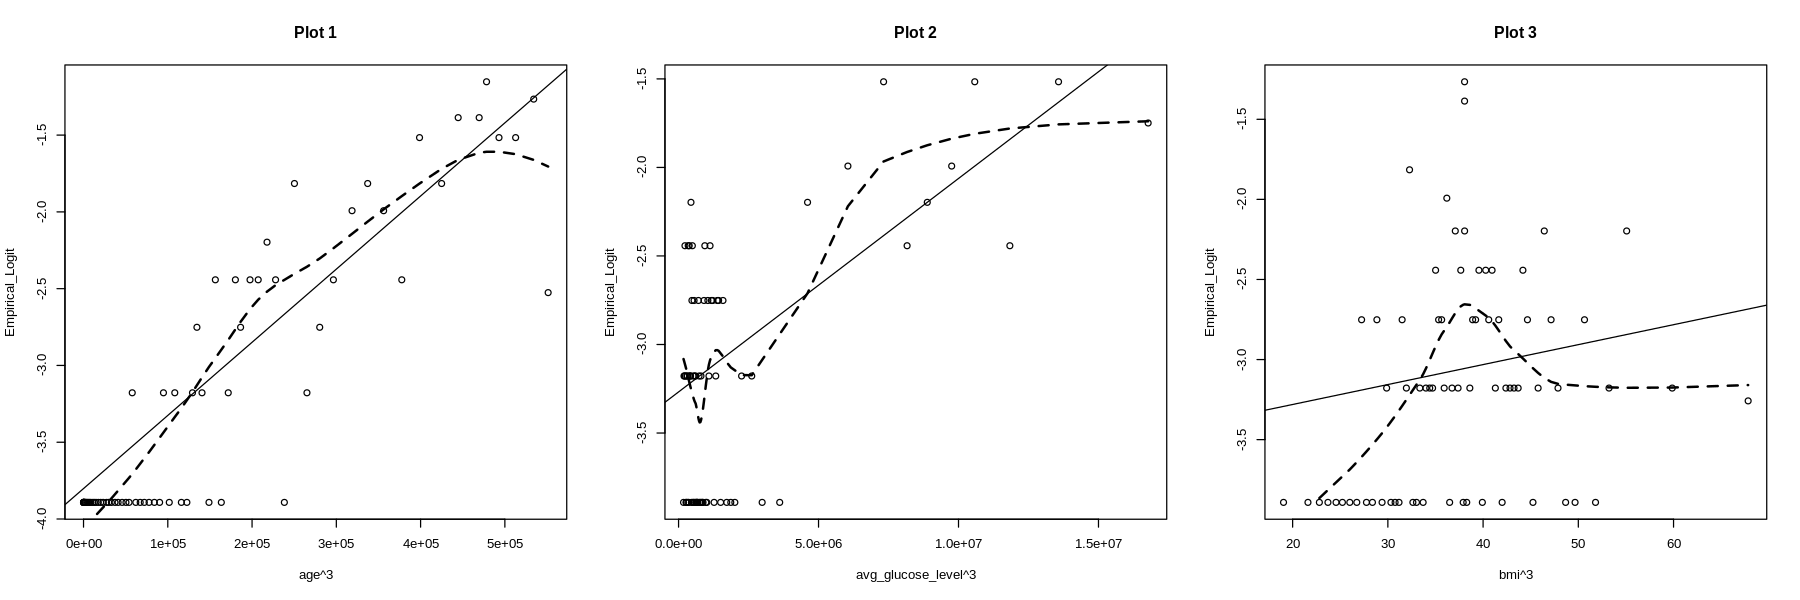

In [8]:
options(repr.plot.width = 15, repr.plot.height = 5)
emplogit = function(x, y, binsize = NULL, ci = FALSE, probit = FALSE,
                    prob = FALSE, main = NULL, xlab = "", ylab = ""){
  # x         vector with values of the independent variable
  # y         vector of binary responses
  # binsize   integer value specifying bin size (optional)
  # ci        logical value indicating whether to plot approximate
  #           confidence intervals (not supported as of 02/08/2015)
  # probit    logical value indicating whether to plot probits instead
  #           of logits
  # prob      logical value indicating whether to plot probabilities
  #           without transforming
  #
  # the rest are the familiar plotting options

  if (length(x) != length(y))
    stop("x and y lengths differ")
  if (any(y < 0 | y > 1))
    stop("y not between 0 and 1")
  if (length(x) < 100 & is.null(binsize))
    stop("Less than 100 observations: specify binsize manually")

  if (is.null(binsize)) binsize = min(round(length(x)/10), 50)

  if (probit){
    link = qnorm
    if (is.null(main)) main = "Empirical probits"
  } else {
    link = function(x) log(x/(1-x))
    if (is.null(main)) main = "Empirical logits"
  }

  sort = order(x)
  x = x[sort]
  y = y[sort]
  a = seq(1, length(x), by=binsize)
  b = c(a[-1] - 1, length(x))

  prob = xmean = ns = rep(0, length(a)) # ns is for CIs
  for (i in 1:length(a)){
    range = (a[i]):(b[i])
    prob[i] = mean(y[range])
    xmean[i] = mean(x[range])
    ns[i] = b[i] - a[i] + 1 # for CI 
  }

  extreme = (prob == 1 | prob == 0)
  prob[prob == 0] = min(prob[!extreme])
  prob[prob == 1] = max(prob[!extreme])

  g = link(prob) # logits (or probits if probit == TRUE)

  linear.fit = lm(g[!extreme] ~ xmean[!extreme])
  b0 = linear.fit$coef[1]
  b1 = linear.fit$coef[2]
    
  loess.fit = loess(g[!extreme] ~ xmean[!extreme])

    plot(xmean, g, main=main, xlab=xlab, ylab=ylab)
    abline(b0,b1)
    lines(loess.fit$x, loess.fit$fitted, lwd=2, lty=2)

}


par(mfrow = c(1, 3))
emplogit(training_stroke$age, training_stroke$stroke, main = "Plot 1", xlab = "age", ylab = "Empirical_Logit")

emplogit(training_stroke$avg_glucose_level, training_stroke$stroke, main = "Plot 2", xlab = "avg_glucose_level", ylab = "Empirical_Logit")

emplogit(training_stroke$bmi, training_stroke$stroke, main = "Plot 3", xlab = "bmi", ylab = "Empirical_Logit")



training_stroke$age<-(training_stroke$age)^3
training_stroke$avg_glucose_level<-(training_stroke$avg_glucose_level)^3
training_stroke$bmi<-log(training_stroke$bmi)^3


emplogit(training_stroke$age, training_stroke$stroke, main = "Plot 1", xlab = "age^3", ylab = "Empirical_Logit")

emplogit(training_stroke$avg_glucose_level, training_stroke$stroke, main = "Plot 2", xlab = "avg_glucose_level^3", ylab = "Empirical_Logit")

emplogit(training_stroke$bmi, training_stroke$stroke, main = "Plot 3", xlab = "bmi^3", ylab = "Empirical_Logit")

The empirical logit plots with untransformed predictors do not look good for the linearity assumption. We have tried several transformation methods to improve the plot and finally chose the polynomial method with degree 3. The result looks better than the untransformed one, especially for the relation of age. But there still is no clear relation to BMI, we may drop it in the future analysis. 

#### Model Selection:
Apply the step function to identify the most significant predictors.

In [9]:
summary(step(logit_model,direction="both"))

Start:  AIC=1114.46
stroke ~ gender + age + hypertension + heart_disease + ever_married + 
    work_type + Residence_type + avg_glucose_level + bmi + smoking_status

                    Df Deviance    AIC
- gender             2   1080.5 1110.5
- smoking_status     3   1082.6 1110.6
- bmi                1   1080.5 1112.5
- Residence_type     1   1080.8 1112.8
- ever_married       1   1080.9 1112.9
- heart_disease      1   1081.4 1113.4
<none>                   1080.5 1114.5
- work_type          4   1090.1 1116.1
- hypertension       1   1085.2 1117.2
- avg_glucose_level  1   1089.4 1121.4
- age                1   1224.6 1256.6

Step:  AIC=1110.47
stroke ~ age + hypertension + heart_disease + ever_married + 
    work_type + Residence_type + avg_glucose_level + bmi + smoking_status

                    Df Deviance    AIC
- smoking_status     3   1082.6 1106.6
- bmi                1   1080.5 1108.5
- Residence_type     1   1080.8 1108.8
- ever_married       1   1080.9 1108.9
- heart_diseas


Call:
glm(formula = stroke ~ age + hypertension + work_type + avg_glucose_level, 
    family = binomial(), data = training_stroke_plot)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0171  -0.3208  -0.1634  -0.0785   3.6880  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -7.214984   1.011853  -7.130    1e-12 ***
age                      0.076263   0.006784  11.242  < 2e-16 ***
hypertension1            0.449844   0.195933   2.296  0.02168 *  
work_typeGovt_job       -0.880983   1.096009  -0.804  0.42151    
work_typeNever_worked   -9.983511 375.146511  -0.027  0.97877    
work_typePrivate        -0.616530   1.076634  -0.573  0.56688    
work_typeSelf-employed  -1.236581   1.104177  -1.120  0.26275    
avg_glucose_level        0.004470   0.001382   3.234  0.00122 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null devia

#### Interpretation:

- We apply both forward and backward selection methods to identify the most significant predictors, guided by the AIC, which balances the model's complexity and explanatory power.

- There are no P-values in the result table, since the step() function aims to find an optimal model by minimizing the AIC, rather than testing the statistical significance of individual predictors.

- We choose the final model glm(formula = stroke ~ age + hypertension + work_type + avg_glucose_level, family = binomial(), data = training_stroke_plot) which has the lowest AIC value (1100.7).

- With our **Research Question** and P-values in the summary table, we can say only 'age', 'hypertension', and 'avg_glucose_level' will statistically significantly influence the likelihood of a patient experiencing a stroke, and work_type will still be included in the model though its P-value is greater than 0.05.

#### Refit the revised logistic model with testing data:

In [10]:
testing_stroke<- testing_stroke%>% 
mutate(stroke = as.factor(stroke))

final_model<- glm(formula = stroke ~ age + hypertension + work_type + avg_glucose_level, family = binomial(), data = testing_stroke)
tidy(final_model,conf.int=TRUE)%>%mutate_if(is.numeric,round,3)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-6.198,1.023,-6.059,0.000,-9.084,-4.641
age,0.075,0.010,7.679,0.000,0.057,0.095
hypertension1,0.285,0.295,0.965,0.335,-0.312,0.849
work_typeGovt_job,-1.433,1.175,-1.220,0.222,-3.448,1.604
work_typeNever_worked,-11.050,547.697,-0.020,0.984,-218.036,7.512
work_typePrivate,-1.521,1.153,-1.319,0.187,-3.479,1.493
work_typeSelf-employed,-1.373,1.187,-1.157,0.247,-3.417,1.677
avg_glucose_level,0.004,0.002,1.785,0.074,0.000,0.008


#### Detailed interpretation of our fitted model:

**Intercept (-6.198)**: The model's intercept, or the log odds of a stroke when all predictors are at their reference level (or zero for continuous variables), is significantly negative. This suggests a low baseline probability of stroke occurrence.

**Age (0.075)**: The coefficient for 'age' is positive and significant (p < 0.000), indicating that as age increases, the likelihood of having a stroke also increases. Given the cubic transformation of age, this effect is non-linear: the impact of age on stroke likelihood accelerates as age increases.

**Hypertension (0.285)**: The coefficient for 'hypertension1' is positive but not statistically significant (p = 0.335). This suggests that, in this model, the presence of hypertension does not significantly increase the odds of having a stroke compared to not having hypertension, although the direction of the effect is as expected.

**Work Type**:

- **Govt_job (-1.433)**: The negative coefficient suggests that being in a government job might be associated with lower odds of stroke compared to the reference category, but this effect is not statistically significant (p = 0.222).
- **Never_worked (-11.050)**: This large negative coefficient is not statistically significant (p = 0.984), likely due to a very small number of observations in this category or extreme values.
- **Private (-1.521)** and **Self-employed (-1.373)**: Similar to 'Govt_job', these work types have negative coefficients indicating possibly lower odds of stroke, but these are not statistically significant.

**Average Glucose Level (0.004)**: The coefficient for 'avg_glucose_level' is positive, indicating that higher average glucose levels are associated with increased odds of stroke. This relationship is approaching statistical significance (p = 0.074) and should be interpreted with caution due to the cubic transformation.

**Model Fit and Significance**: The overall model has identified some key predictors of stroke. However, the significance of these predictors varies, with 'age' being the most significant predictor. The transformed nature of the continuous variables suggests a non-linear relationship with the probability of stroke.

**Confidence Intervals**: The confidence intervals provide a range within which the true population parameter is likely to lie. For significant predictors like 'age', the confidence interval does not include zero, reinforcing the significance of this predictor.


#### Variable importance table:

In [11]:
varImp(final_model)

,Overall
,<dbl>
age,7.67892816
hypertension1,0.96485234
work_typeGovt_job,1.21996420
work_typeNever_worked,0.02017627
work_typePrivate,1.31923950
work_typeSelf-employed,1.15677338
avg_glucose_level,1.78525688


The Variable importance table shows that the age is the most important one, corresponding to the result in the summary of refit model. 

Therefore, age is the most significant variable which most influences the likelihood of a patient experiencing a stroke in our Research Question.

#### The Goodness of Fit: 
Hosmer-Lemeshow Test is used. 

In [12]:
hoslem_test <- hoslem.test(testing_stroke$stroke, fitted(final_model), g = 10)
print(hoslem_test)


	Hosmer and Lemeshow goodness of fit (GOF) test

data:  testing_stroke$stroke, fitted(final_model)
X-squared = 1533, df = 8, p-value < 2.2e-16



The P-value < 2.2e-16 in the Hosmer-Lemeshow Test indicates that our final model may not be a good fit of our dataset.